In [344]:
from __future__ import annotations
import numpy as np
import itertools
from multiprocessing import Pool
from tqdm import tqdm
import pandas as pd
from scipy.optimize import linprog
from typing import Dict, List, Optional, Tuple, Iterable
from scipy.optimize import linprog
import sys
import os
import matplotlib.pyplot as plt
import time

sys.path.append('../')


# Region class

In [345]:
# Region class as dataclass
class Region:
    def __init__(self, activation=None):
        # Region attributes
        self.q = activation # Activation pattern
        self.q_tilde = None # Active bits in activation pattern (indices)
        self.ineqs = None # Inequalities in the form [A c] #TODO -c?
        
        # Tree attributes
        self.parent = None # Parent Region object
        self.children = [] # List of children (Region objects)
        
        # Utility attributed
        self.layer_number = 0 # Layer to which this region belongs
        self.region_index = 0 # Index to identify regions #TODO necessary?
        
    def add_child(self, child):
        child.parent = self
        self.children.append(child)
        
    def is_leaf(self):
        return len(self.children) == 0
    
    def is_root(self):
        return self.parent is None
    
    def get_children(self):
        return self.children
    
    def get_depth(self):
        depth = 0
        node = self
        while node.parent is not None:
            node = node.parent
            depth += 1
        assert depth == self.layer_number, "Depth and layer number are not equal"
        return depth
    
    def get_ancestors(self):
        ancestors = []
        node = self
        
        while node.parent is not None:
            ancestors.append(node.parent)
            node = node.parent
        
        return ancestors[::-1]
    
    def get_path_inequalitites(self):
        inequalities = []
        node = self
        
        while node.parent is not None:
            if node.ineqs is not None:
                inequalities.append(node.ineqs)
            node = node.parent
            
        return np.vstack(inequalities[::-1]) if inequalities else None
        
        

# Logic begin building the tree

## Make state dict

In [346]:
# Make a dummy state dict
from src_experiment import NeuralNet

model = NeuralNet(
    input_size = 2,
    hidden_sizes = [5,25,25],
    num_classes=2,
    # seed=3,
)
sd = model.state_dict()
sd

OrderedDict([('l1.weight',
              tensor([[ 0.3165, -0.5478],
                      [ 0.1666, -0.5769],
                      [ 0.5285,  0.1378],
                      [ 0.6172,  0.2810],
                      [-0.0266, -0.6070]])),
             ('l1.bias',
              tensor([ 0.3549,  0.5134,  0.1480, -0.1306, -0.5536])),
             ('l2.weight',
              tensor([[-0.3487, -0.1681,  0.3897, -0.2851, -0.2590],
                      [ 0.3599,  0.2104, -0.0733,  0.3365,  0.0798],
                      [-0.3963,  0.3921,  0.3810,  0.0610, -0.4318],
                      [-0.3635,  0.1472,  0.1065, -0.1434,  0.0572],
                      [ 0.3668, -0.2217,  0.0088, -0.2296, -0.2797],
                      [ 0.2571,  0.0111,  0.1486,  0.1381,  0.0245],
                      [-0.2805,  0.1148, -0.4430,  0.0070,  0.3784],
                      [-0.4028, -0.1035,  0.3881,  0.0737, -0.0239],
                      [ 0.1149,  0.0075,  0.1330, -0.3922, -0.0551],
                 

## Find the hyperplanes

In [347]:
def find_hyperplanes(state_dict):
    weights = []
    biases = []
    hyperplanes = [] 
    for key, val in state_dict.items():
        if "weight" in key:
            weights.append(val)
        elif "bias" in key:
            biases.append(val)
    for W, b in zip(weights, biases):
        hyperplanes.append(np.hstack((W, b.reshape(-1,1))))
    return hyperplanes
H = find_hyperplanes(sd)

## Extract $W$ and $b$ and find $x_0$ "random" point

In [348]:
# For the first step, the root node is the parent, it should be initializes without an activation pattern

# Root initialization
root = Region()

# Work with the first layer - regions induced by the first layer of the network
# Weigths and biases of first layer
W1, b1 = H[1-1][:,:-1], H[1-1][:,-1].reshape(-1,1)

# "random" point in input space x0 has shape (d_input, 1)
x0 = np.random.randint(-10,10,size=W1[0,:].shape).reshape(-1,1)
x0

array([[8],
       [4]])

## Visualize hyperplanes and points

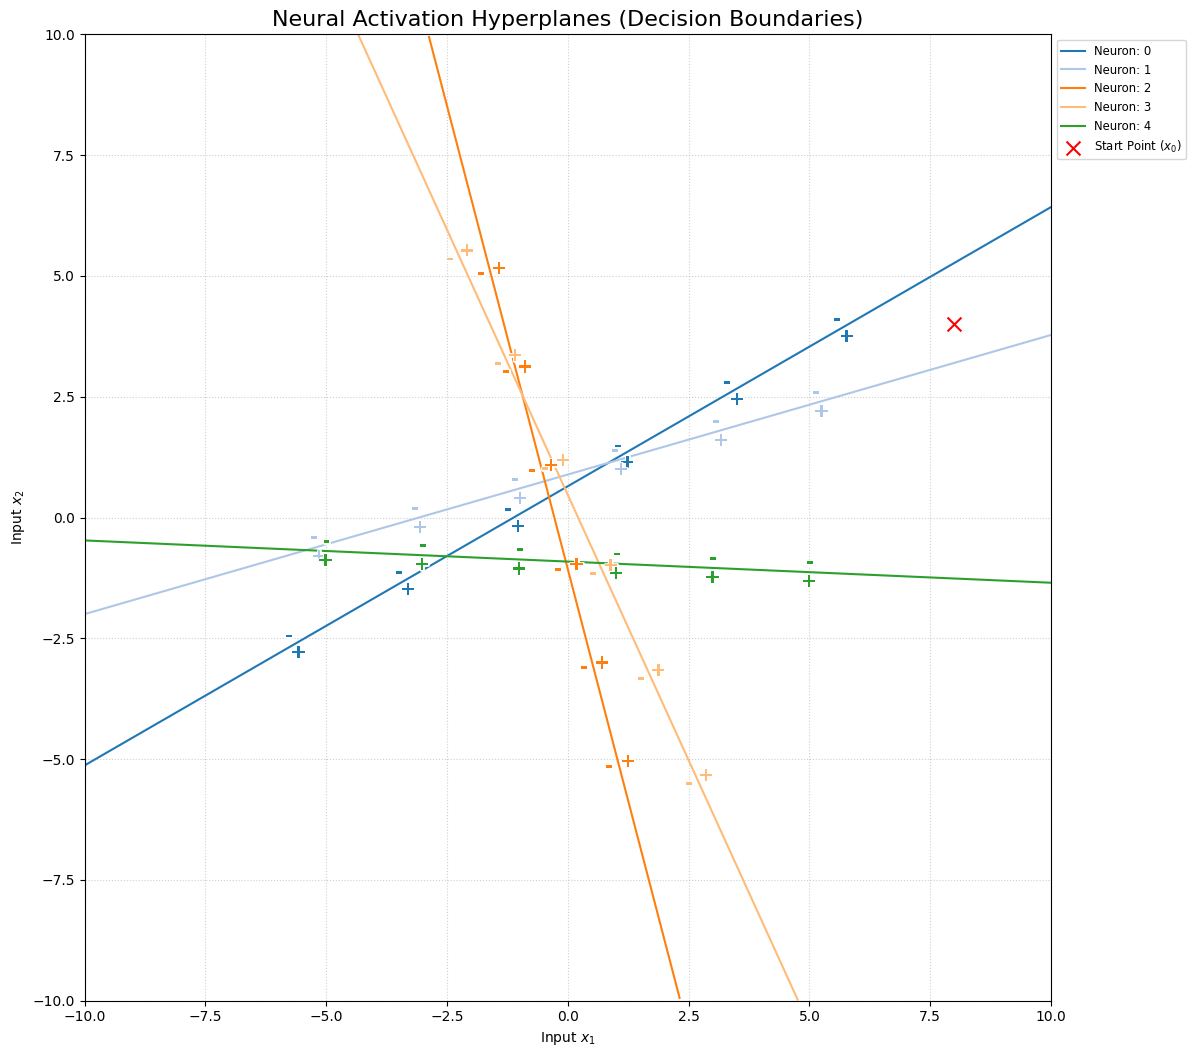

In [372]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from itertools import cycle

# --- 1. Data and State Setup ---
# Assuming W1 and b1 are already defined from your neural network layers
# Example dummy data if not defined:
# W1 = np.array([[1, 1], [1, -1], [0, 1]])
# b1 = np.array([10, -5, 20])
# x0 = np.array([0, 0])

# fac = 8
# x_min, x_max = -fac, fac
# y_min, y_max = -fac, fac

# Initialize dictionaries
traversed = {}
# Using tab20 to get 20 distinct colors before repeating
color_pool = cycle(plt.cm.tab20.colors)

def to_tuple(array):
    """Converts a 1D numpy array to a hashable tuple."""
    return tuple(array.ravel())

# --- 2. Helper Functions ---

def clip_to_bounds(x, y, x_min, x_max, y_min, y_max):
    return (x_min <= x <= x_max) and (y_min <= y <= y_max)

def plot_hyperplane(ax, w, b, color, label, offset=0.15, num_marks=6, fac=5):
    """Plot a hyperplane with +/- markers showing the activation direction."""
    # Check if the line is not perfectly vertical
    x_min, x_max = -fac, fac
    y_min, y_max = -fac, fac

    if abs(w[1]) > 1e-6:
        x_vals = np.linspace(x_min, x_max, 1000)
        y_vals = -(w[0]*x_vals + b)/w[1]
        mask = (y_vals >= y_min) & (y_vals <= y_max)
        
        if np.any(mask):
            x_line, y_line = x_vals[mask], y_vals[mask]
            ax.plot(x_line, y_line, color=color, label=label, linewidth=1.5)

            # Normal vector for marker direction
            n = w / np.linalg.norm(w)
            
            # Interpolate points along the visible segment for markers
            ds = np.sqrt(np.diff(x_line)**2 + np.diff(y_line)**2)
            s = np.concatenate(([0], np.cumsum(ds)))
            s_targets = np.linspace(s[0] + 5, s[-1] - 5, num_marks)
            x_marks = np.interp(s_targets, s, x_line)
            y_marks = np.interp(s_targets, s, y_line)

            for xm, ym in zip(x_marks, y_marks):
                # Calculate positive and negative side positions
                for sign, direction in [('+', 1), ('-', -1)]:
                    xt, yt = xm + direction * offset * n[0], ym + direction * offset * n[1]
                    if clip_to_bounds(xt, yt, x_min, x_max, y_min, y_max):
                        ax.text(xt, yt, sign, color=color, ha='center', va='center', 
                                fontsize=14, weight='bold',
                                path_effects=[pe.withStroke(linewidth=2, foreground="white")])
    else:
        # Vertical line case (w[1] is 0)
        x_line = -b/w[0]
        if x_min <= x_line <= x_max:
            ax.axvline(x_line, color=color, label=label, linewidth=1.5)
            n = w / np.linalg.norm(w)
            y_marks = np.linspace(y_min + 10, y_max - 10, num_marks)
            for ym in y_marks:
                for sign, direction in [('+', 1), ('-', -1)]:
                    xt = x_line + direction * offset * n[0]
                    if clip_to_bounds(xt, ym, x_min, x_max, y_min, y_max):
                        ax.text(xt, ym, sign, color=color, ha='center', va='center', 
                                fontsize=14, weight='bold',
                                path_effects=[pe.withStroke(linewidth=2, foreground="white")])

# --- 3. Plotting Execution ---

fig, ax = plt.subplots(figsize=(12, 12))
fac = 10
# Iterate through weights and biases to plot hyperplanes
for n, (we, be) in enumerate(zip(W1, b1)):
    # Get a real color from the cycle (Crucial fix)
    current_color = next(color_pool)
    
    # We pass a higher offset (e.g., 4.0) because the coordinate space is 200 units wide
    plot_hyperplane(ax, we, be, color=current_color, label=f"Neuron: {n}", offset=fac/50, fac=fac)

# Mark the specific point x0
ax.scatter(x0[0], x0[1], marker="x", color="red", s=100, label="Start Point ($x_0$)", zorder=5)

# Formatting the plot
ax.set_xlim(-fac, fac)
ax.set_ylim(-fac, fac)
ax.set_aspect('equal')
ax.grid(True, linestyle=':', alpha=0.6)

# Move legend outside if there are many neurons
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', ncol=1)

plt.title("Neural Activation Hyperplanes (Decision Boundaries)", fontsize=16)
plt.xlabel("Input $x_1$")
plt.ylabel("Input $x_2$")
plt.tight_layout()
plt.show()

## Find $q_0$ - activation pattern of $x_0$

In [350]:
def find_activation_pattern(x, W, b, W_proj=None, b_proj=None):
    if W_proj is None and b_proj is None:
        z = W @ x + b
        return (z>0).astype(int)
    else:
        #FIXME
        pass
    
q0 = find_activation_pattern(x0, W1, b1)
q0

array([[1],
       [0],
       [1],
       [1],
       [0]])

## Find $\tilde{q_0}$ - Active bits of $q_0$

In [351]:
def get_signs_from_activation(activation: np.ndarray) -> np.ndarray:
    """Convert activation vector {0, 1} to sign vector {-1, 1}."""
    return -2 * activation + 1
s = get_signs_from_activation(q0)

In [352]:
ds = np.diag(s.ravel())

In [353]:
import numpy as np
from scipy.optimize import linprog
import multiprocessing as mp


def _solve_single_lp(args):
    """
    Worker function: tests whether constraint i is non-redundant.
    Returns i if active, -1 otherwise.
    """
    i, A, c, tol = args

    n_constraints, d = A.shape
    a_i = A[i]

    A_tilde = np.delete(A, i, axis=0)
    c_tilde = np.delete(c, i, axis=0)

    bounds = [(None, None)] * d

    res = linprog(
        c=-a_i,
        A_ub=A_tilde,
        b_ub=c_tilde,
        bounds=bounds,
        method="highs",
    )

    if res.status == 3:  # unbounded
        return i, False
        


    max_val = -res.fun
    ci = c[i]

    if max_val > ci + tol:
        return i, True
    else:
        return -1, True

def find_active_bits_parallel(q, hp, n_jobs=None, tol=1e-7, verbose=False):
    """
    Parallel version of find_active_bits using scipy.linprog (HiGHS).
    """
    s = get_signs_from_activation(q)
    ds = np.diag(s.ravel())
    A = ds @ hp[:,:-1]
    c = ds @ -hp[:,-1]

    A = np.asarray(A)
    c = np.asarray(c).reshape(-1)

    n_constraints = A.shape[0]

    if n_jobs is None:
        n_jobs = mp.cpu_count()

    tasks = [(i, A, c, tol) for i in range(n_constraints)]

    active_bits = []
    bounded_global = True
    with mp.Pool(processes=n_jobs) as pool:
        for k, (res, bounded) in enumerate(pool.imap_unordered(_solve_single_lp, tasks)):
            if res != -1:
                active_bits.append(res)
            if not bounded:
                bounded_global = False
            
            if verbose and (k + 1) % 5 == 0:
                print(f"Processed {k + 1}/{n_constraints}")

    return np.array(sorted(active_bits)), bounded_global


q0_tilde, bounded = find_active_bits_parallel(q0, H[0], n_jobs=8, verbose=True)

print(f"q: {tuple(q0.ravel().tolist())}\nq_tilde: {tuple(q0_tilde.ravel().tolist())}\nBounded: {bounded}")

Processed 5/5
q: (1, 0, 1, 1, 0)
q_tilde: (0, 1)
Bounded: False


## Iterate through active bits and accumulate neighbours

In [354]:
# Create dicts to keep track of the activations. 

traversed = {} # Dictionary of traversed activation patterns
actives = {} # Dictionary with indices of active neurons for each activation

def to_tuple(array):
    return tuple(array.ravel().tolist())

traversed[to_tuple(q0)] = True
actives[to_tuple(q0)] = q0_tilde

In [355]:
# Iterate through and change the actvie indices

for active_idx in q0_tilde:
    q_new = q0.copy()
    q_new[active_idx] ^= 1  # 0 becomes 1, 1 becomes 0
    traversed[to_tuple(q_new)] = False

In [356]:
 # 1. Initialize
traversed = {} # Dictionary of traversed activation patterns
actives = {} # Dictionary with indices of active neurons for each activation
queue = [to_tuple(q0)]
traversed[to_tuple(q0)] = True

# 2. Process until no new states are found
while queue:
    current_key = queue.pop(0)  # Get the next state to process
    
    # Logic to find the active indices for this specific state
    # (Assuming you have a function or lookup for this)
    current_q = np.array(current_key)
    current_active_indices, _ = find_active_bits_parallel(current_q, H[0]) 
    actives[current_key] = current_active_indices
    print(current_key)
    
    for active_idx in current_active_indices:
        # Generate neighbor
        q_new = current_q.copy()
        q_new[active_idx] ^= 1
        new_key = to_tuple(q_new)
        
        # 3. Only add if we haven't seen it before
        if new_key not in traversed:
            traversed[new_key] = False
            queue.append(new_key)  # Add to queue to be processed in a future loop
            
    # Mark the current one as fully processed
    traversed[current_key] = True

(1, 0, 1, 1, 0)
(0, 0, 1, 1, 0)
(1, 1, 1, 1, 0)
(0, 1, 1, 1, 0)
(0, 0, 0, 1, 0)
(0, 0, 1, 0, 0)
(1, 1, 1, 0, 0)
(1, 1, 1, 1, 1)
(0, 1, 1, 0, 0)
(0, 0, 0, 0, 0)
(1, 1, 0, 0, 0)
(1, 1, 1, 0, 1)
(0, 1, 0, 0, 0)
(0, 0, 0, 0, 1)
(1, 1, 0, 0, 1)
(0, 1, 0, 0, 1)


In [357]:
len(traversed)

16

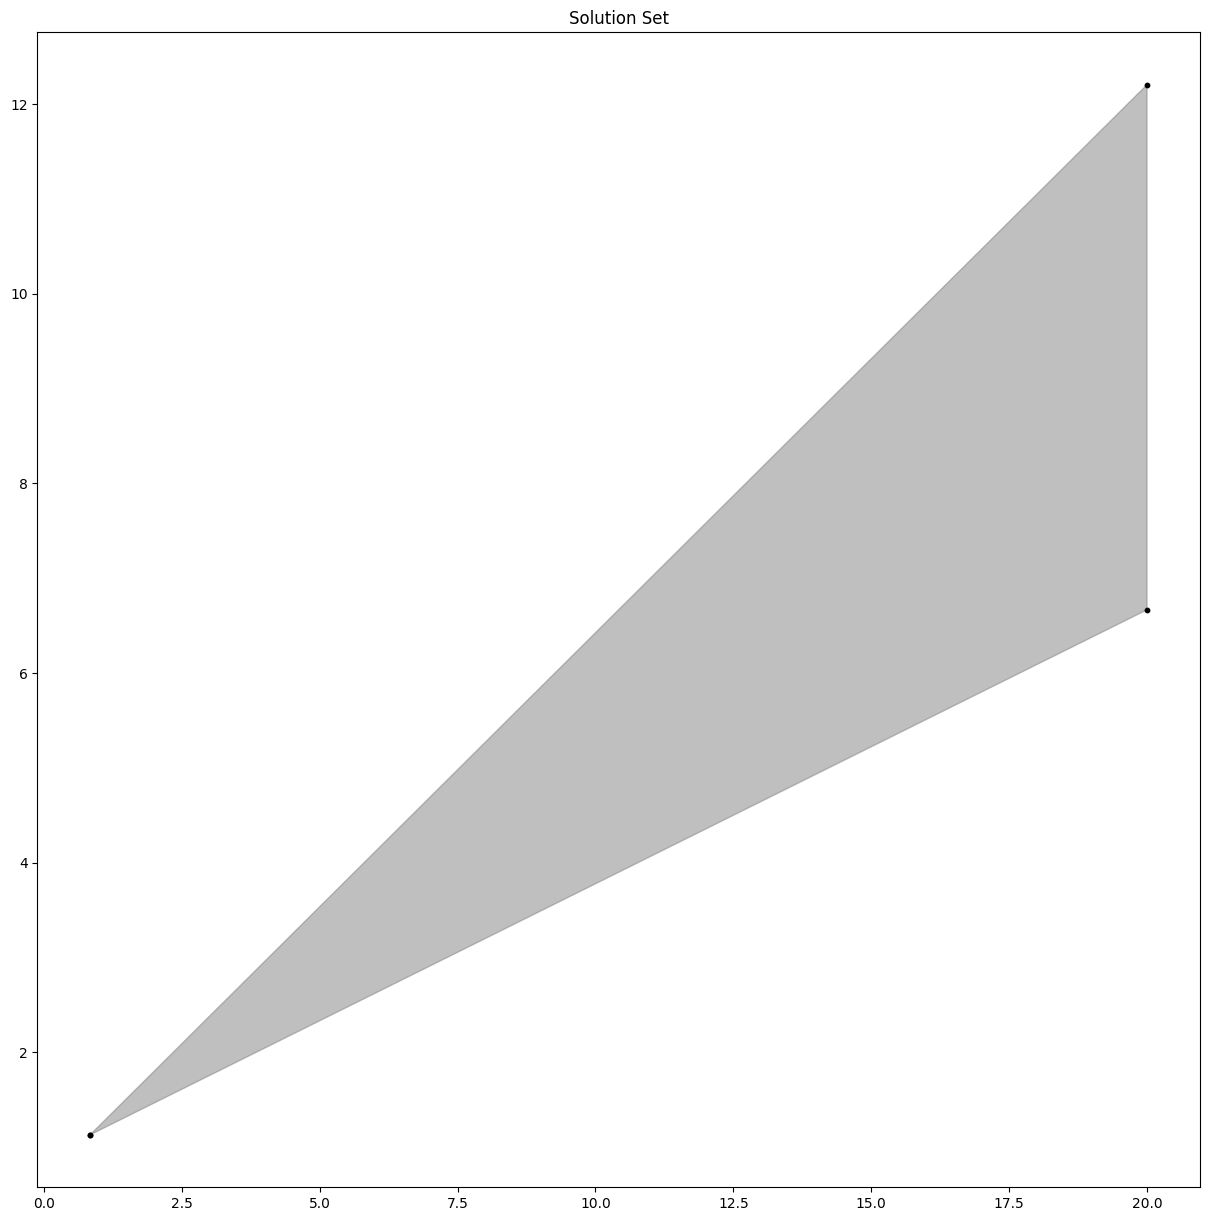

In [361]:
from intvalpy import lineqs
fac = 20

bounds = [[-fac, -fac], [fac, fac]]
def get_A_c(q, hp):
    s = get_signs_from_activation(q)
    ds = np.diag(s.ravel())
    
    A = ds @ hp[:,:-1]
    c = ds @ -hp[:,-1]
    return A, c

A0, c0 = get_A_c(q0, H[0])
verts = lineqs(-A0, -c0, bounds=bounds)

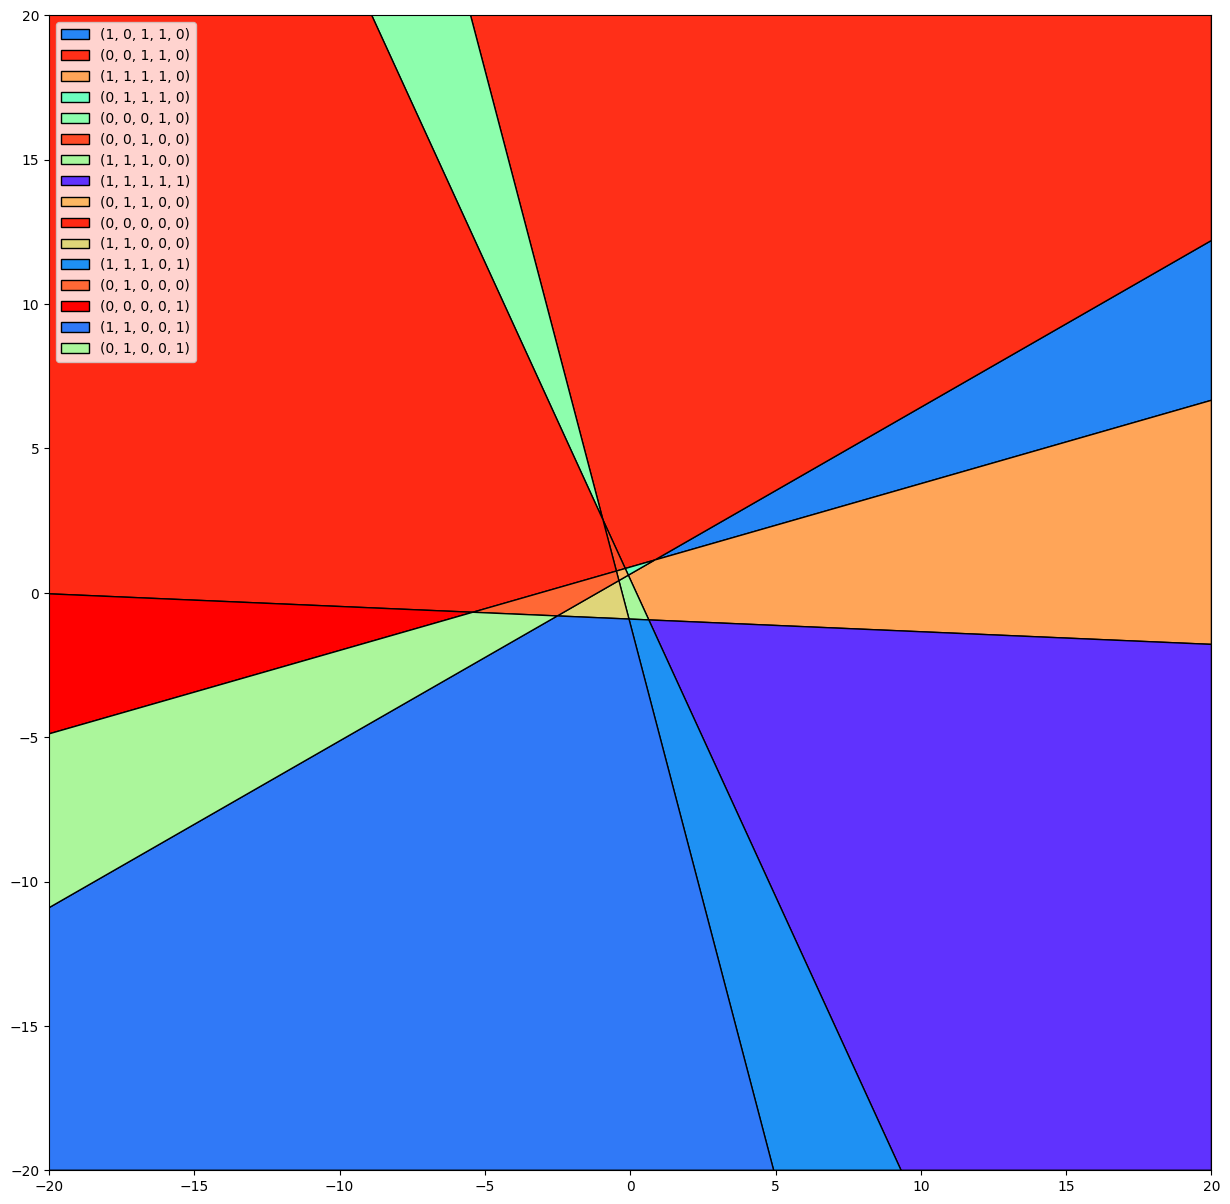

In [368]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
colors = [np.random.randint(1, 300) for i in range(len(traversed))]
cmap = matplotlib.colormaps['rainbow']

polygons = []
for i, q in enumerate(traversed.keys()):
    q_arr = np.array(q)
    A, c = get_A_c(q_arr, H[0])
    verts = lineqs(-A, -c, bounds=bounds, show=False)
    
    polygon = Polygon(xy=verts, facecolor=cmap(colors[i]), edgecolor="black", label=f"{q}")
    
    polygons.append(polygon)

fig, ax = plt.subplots(figsize=(15,15))

for p in polygons:
    ax.add_patch(p)
    ax.legend()
    ax.set_xlim([-fac, fac])
    ax.set_ylim([-fac, fac])

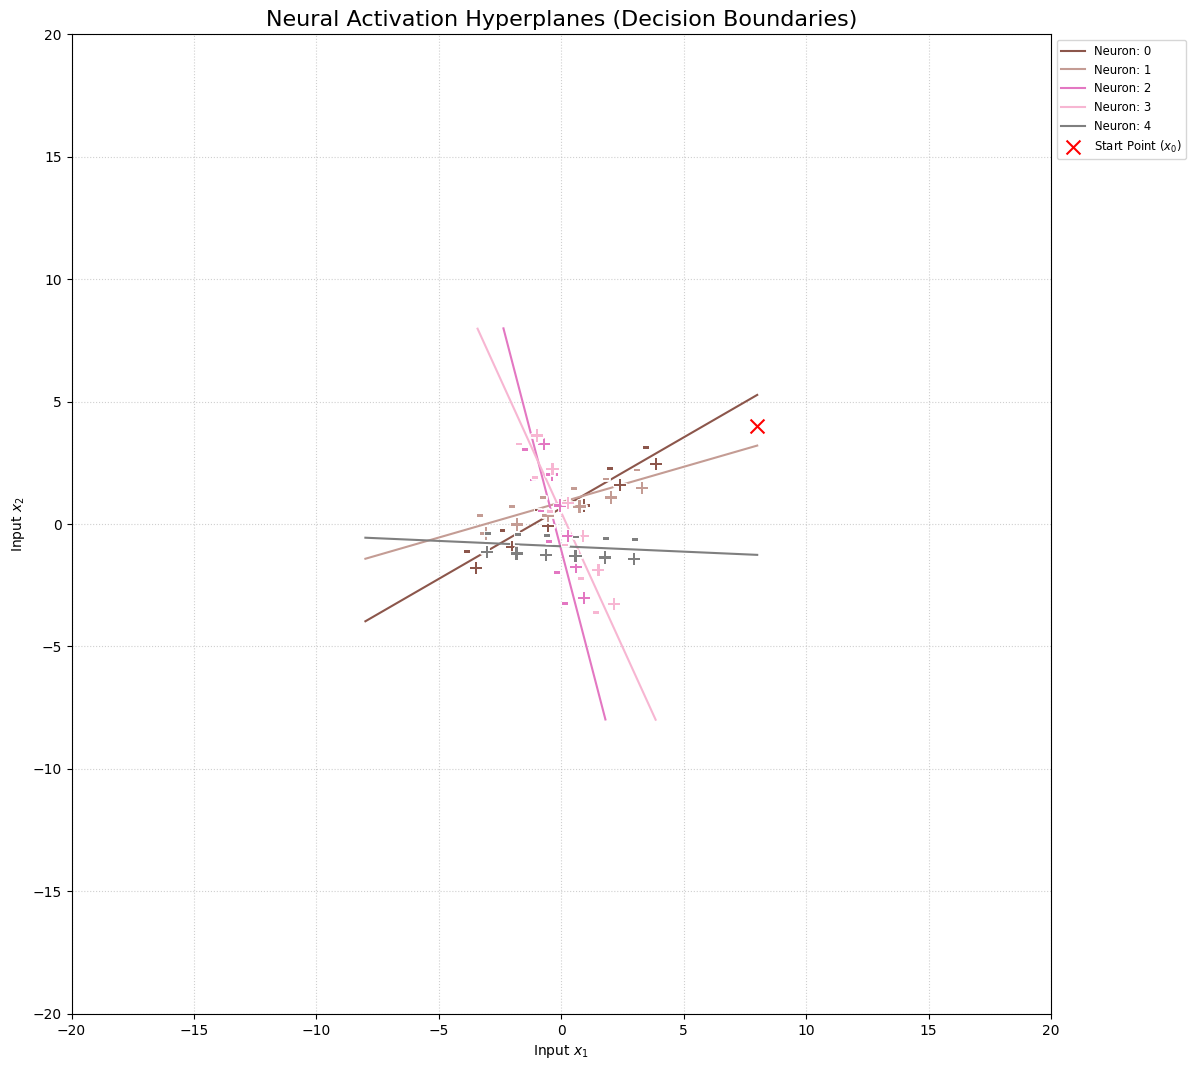

In [370]:
fig, ax = plt.subplots(figsize=(12, 12))

# Iterate through weights and biases to plot hyperplanes
for n, (we, be) in enumerate(zip(W1, b1)):
    # Get a real color from the cycle (Crucial fix)
    current_color = next(color_pool)
    
    # We pass a higher offset (e.g., 4.0) because the coordinate space is 200 units wide
    plot_hyperplane(ax, we, be, color=current_color, label=f"Neuron: {n}", offset=fac/50)

# Mark the specific point x0
ax.scatter(x0[0], x0[1], marker="x", color="red", s=100, label="Start Point ($x_0$)", zorder=5)

# Formatting the plot
ax.set_xlim([-fac, fac])
ax.set_ylim([-fac, fac])
ax.set_aspect('equal')
ax.grid(True, linestyle=':', alpha=0.6)

# Move legend outside if there are many neurons
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', ncol=1)

plt.title("Neural Activation Hyperplanes (Decision Boundaries)", fontsize=16)
plt.xlabel("Input $x_1$")
plt.ylabel("Input $x_2$")
plt.tight_layout()
plt.show()